In [72]:
using Plots 
using Revise
cd("..")
include("RBFunctions.jl")
cd("circular_stokes_flow")
include("kernel_definitions.jl")
using .SomeModule
using BenchmarkTools
using Symbolics
using Latexify
using CairoMakie
using LinearAlgebra

ABCD

10

In [2]:
@variables x₁, x₂, t
u₁ = (1-x₂^2)*sin(π*t)
u₂ = 0.0
p = -2*x₁*sin(π*t)
∂ₜu₁ = ∂ₜ(u₁)
∂ₜu₂ = 0.0
f₁ = 0.0
f₂ = 0.0
∂₁p = ∂₁(p)
∂₂p = 0# ∂₂(p)

u₁  = eval(build_function(u₁, x₁, x₂, t))
u₂  = eval(build_function(u₂, x₁, x₂, t))
p   = eval(build_function(p, x₁, x₂, t))
∂ₜu₁ = eval(build_function(∂ₜu₁, x₁, x₂, t))
∂ₜu₂ = eval(build_function(∂ₜu₂, x₁, x₂, t))
f₁  = eval(build_function(f₁, x₁, x₂, t))
f₂  = eval(build_function(f₂, x₁, x₂, t))
∂₁p = eval(build_function(∂₁p, x₁, x₂, t))
∂₂p = eval(build_function(∂₂p, x₁, x₂, t))

#23 (generic function with 1 method)

set up the problem 
compute L_I L_b matrices 
Compute P matrix 


In [63]:
#generate points for channel_flow
nx = 40
ny = 20
x  = LinRange(0,4,nx)
y =  LinRange(-1,1,ny)
XX = x' .* ones(ny)
YY = ones(nx)' .* y[end:-1:1]
points = hcat(vec(XX),vec(YY))'

#display(XX)
#display(YY)
#display(points)

Internal_points = []
Boundary_points = []
suma = 0
for i in 1:size(points)[2]
    if points[1,i] == 0 || points[1,i] == 4
        append!(Boundary_points,[points[:,i]])
    elseif points[2,i] == -1 || points[2,i] == 1
        append!(Boundary_points,[points[:,i]])
    else
        append!(Internal_points,[points[:,i]])
    end
    
end

Internal_points = hcat(Internal_points...)
Boundary_points = hcat(Boundary_points...)
All_points = hcat(Internal_points,Boundary_points)
N_i = size(Internal_points)[2]
N_b = size(Boundary_points)[2]
N = N_i + N_b
println("total number of nodes: ",N)




total number of nodes: 800


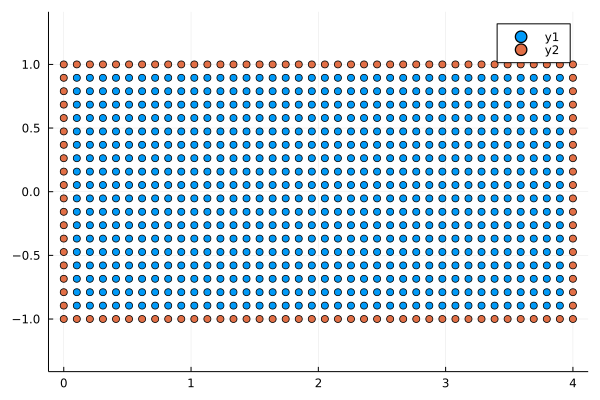

In [64]:
# plot the domain and boundary points 
Plots.scatter(Internal_points[1,:],Internal_points[2,:],aspect_ratio=:equal)
Plots.scatter!(Boundary_points[1,:],Boundary_points[2,:],aspect_ratio=:equal)

In [68]:
# generate vector functions 

ux_true = generate_vector_function(u₁,Internal_points)
uy_true = generate_vector_function(u₂,Internal_points)
u_true_internal = generate_vector_function(u₁,u₂,Internal_points)
g = generate_vector_function(u₁,u₂,Boundary_points) # function values on the boundary 
f = generate_vector_function(f₁,f₂,Internal_points) # forcing function on the domain 
∇p = generate_vector_function(∂₁p,∂₂p,Internal_points) # forcing function on the domain 
∂ₜg = generate_vector_function(∂ₜu₁,∂ₜu₂,Boundary_points)


(::var"#aa#6"{var"#13#14", var"#15#16", Vector{Float64}, Vector{Float64}, Int64}) (generic function with 1 method)

In [6]:


time = Observable(0.0)
xs = Internal_points[1,:]
ys = Internal_points[2,:]
us = @lift ux_true($time)
vs = @lift uy_true($time)
title = @lift string(round($time, digits=2))
strength2 = @lift (sqrt.(ux_true($time+0.01) .^ 2 .+ uy_true($time+0.01) .^ 2) )

fig = Figure(resolution = (800, 800))
Axis(fig[1, 1], backgroundcolor = "black",title = title)
arrows!(xs, ys, us, vs, arrowsize = 10, lengthscale = 0.2, arrowcolor = strength2, linecolor = strength2) #, 
framerate = 30
timestamps = range(0.0, 2π, step=1/framerate)
record(fig, "time_animation.gif", timestamps; framerate = framerate) do ti
    time[] = ti
end
print(strength2)

Observable{Vector{Float64}} with 2 listeners. Value:
[0.20263976269898631, 0.37410417729043627, 0.5143932437743503, 0.6235069621507274, 0.7014453324195684, 0.748208354580873, 0.7637960286346411, 0.748208354580873, 0.7014453324195683, 0.6235069621507274, 0.5143932437743503, 0.37410417729043655, 0.20263976269898631, 0.20263976269898631, 0.37410417729043627, 0.5143932437743503, 0.6235069621507274, 0.7014453324195684, 0.748208354580873, 0.7637960286346411, 0.748208354580873, 0.7014453324195683, 0.6235069621507274, 0.5143932437743503, 0.37410417729043655, 0.20263976269898631, 0.20263976269898631, 0.37410417729043627, 0.5143932437743503, 0.6235069621507274, 0.7014453324195684, 0.748208354580873, 0.7637960286346411, 0.748208354580873, 0.7014453324195683, 0.6235069621507274, 0.5143932437743503, 0.37410417729043655, 0.20263976269898631, 0.20263976269898631, 0.37410417729043627, 0.5143932437743503, 0.6235069621507274, 0.7014453324195684, 0.748208354580873, 0.7637960286346411, 0.748208354580873, 

In [69]:
# calculate matrices for the simulation 
param = 4
tensor_internal_internal =(point_difference_tensor(Internal_points,Internal_points))
tensor_internal_all = (point_difference_tensor(Internal_points,All_points))
tensor_all_all = (point_difference_tensor(All_points,All_points))
tensor_internal_boundary = (point_difference_tensor(Internal_points,Boundary_points))
tensor_boundary_boundary = (point_difference_tensor(Boundary_points,Boundary_points))


# from the paper 
A = (apply_matrix(Φ, tensor_internal_internal, param))
A_div = (apply_matrix(Φ_div, tensor_internal_internal, param))
B = (apply_matrix(Φ_div, tensor_internal_boundary, param))
C = (apply_matrix(Φ_div, tensor_boundary_boundary, param))

AA = vcat(hcat(A,B),hcat(B',C))
AB = hcat(A_div,B)
Px = AB*inv(AA)
Pi = Px[:,1:2*N_i]
Pb = Px[:,2*N_i+1:end]

Ax = (apply_matrix(Φ_normal, tensor_all_all, param))
AL = (apply_matrix(ΔΦ_normal, tensor_all_all, param))
L = AL*inv(Ax)
Li = L[1:2*N_i,1:2*N_i]
Lb = L[1:2*N_i,2*N_i+1:end]

println("cond AA: ",cond(AA))
println("cond Ax: ",cond(Ax))
println("cond Pi*Li :",cond(Pi*Li))
println("max eigenval: ",maximum(real.(eigvals(Pi*Li))))




cond AA: 2.101715188307089e9
cond Ax: 1.5146688149857166e11
cond Pi*Li :3.432989977942008e14
max eigenval: 1.892403157789165e-7


In [70]:
using DifferentialEquations
using Sundials

function f2!(du,u,p,t) # paper version
    Li,Lb,Pi,Pb,f,g,∂ₜg,∇p = p

    du .=   Pi * (Li * u .+ Lb * g(t) .+ f(t) ) .+ Pb*∂ₜg(t)
end

u0 = u_true_internal(0)
tspan = (0.0,2.0)

prob2 = ODEProblem(f2!,u0,tspan,[Li,Lb,Pi,Pb,f,g,∂ₜg,∇p])
sol = solve(prob2,ImplicitEuler())
println("done")

done


In [71]:
println(maximum(abs.(sol(1.3) - u_true_internal(1.3))))
println(maximum(vcat(sol[:]...)))
println(maximum(vcat(u_true_internal.(0:0.1:2)...)))
maximum(abs.(vcat(u_true_internal.(0:0.01:2)...) - vcat(sol(0:0.01:2)...)))


0.035470475068082985
0.9792814901353114
0.997229916897507


0.054079731437322046

In [73]:

t_interest = 1.3
xsi = Internal_points[1,:]
ysi = Internal_points[2,:]

u = sol(t_interest)[1:2:2*N_i]
v = sol(t_interest)[2:2:2*N_i]

usi = f(t_interest)[1:2:2*N_i]
vsi = f(t_interest)[2:2:2*N_i]

up = ∇p(t_interest)[1:2:2*N_i]
vp = ∇p(t_interest)[2:2:2*N_i]

xsb = Boundary_points[1,:]
ysb = Boundary_points[2,:]
usb = g(t_interest)[1:2:2*N_b]
vsb = g(t_interest)[2:2:2*N_b]

strengthi = (sqrt.( usi.^ 2 .+  vsi.^ 2) )
strengthb = (sqrt.( usb.^ 2 .+  vsb.^ 2) )
strengthp = (sqrt.( (up.+0.0).^ 2 .+  (vp .+0.0).^ 2) )
strengthsol = (sqrt.( (u.+0.0).^ 2 .+  (v .+0.0).^ 2) )

fig = Figure(resolution = (3*400, 2*400))
subfig1 = fig[1, 1] = GridLayout()
subfig2 = fig[1, 2] = GridLayout()
subfig3 = fig[1, 3] = GridLayout()
subfig4 = fig[2, 1] = GridLayout()
ax1 = Axis(subfig1[1, 1], backgroundcolor = "black",title = "forcing")
ax2 = Axis(subfig2[1, 1], backgroundcolor = "black",title = "boundary velocity")
ax3 = Axis(subfig3[1, 1], backgroundcolor = "black",title = "pressure gradient")
ax4 = Axis(subfig4[1, 1], backgroundcolor = "black",title = "velocity")
arrows!(ax1,xsi, ysi, usi, vsi, arrowsize = 10, lengthscale = 0.2, arrowcolor = strengthi, linecolor = strengthi) #,
arrows!(ax2,xsb, ysb, usb, vsb, arrowsize = 10, lengthscale = 0.2, arrowcolor = strengthb, linecolor = strengthb) #,
arrows!(ax3,xsi, ysi, up, vp, arrowsize = 10, lengthscale = 0.2, arrowcolor = strengthp, linecolor = strengthp) #,
arrows!(ax4,xsi, ysi,u , v, arrowsize = 10, lengthscale = 0.2, arrowcolor = strengthsol, linecolor = strengthsol)
fig

Figure()

In [74]:
time = Observable(0.0)
xs = Internal_points[1,:]
ys = Internal_points[2,:]
us = @lift sol($time)[1:2:2*N_i] - ux_true($time)
vs = @lift sol($time)[2:2:2*N_i] - uy_true($time)
title = @lift string(round($time, digits=2))
strength2 = @lift sqrt.(sol($time+0.01)[1:2:2*N_i] .^ 2 .+ sol($time+0.01)[2:2:2*N_i] .^ 2) 

fig = Figure(resolution = (800, 800))
Axis(fig[1, 1], backgroundcolor = "black",title = title)
arrows!(xs, ys, us, vs, arrowsize = 10, lengthscale = 0.5, arrowcolor = strength2, linecolor = strength2) #, 
framerate = 30
timestamps = range(0.0, 2, step=1/framerate)
record(fig, "channel.gif", timestamps; framerate = framerate) do ti
    time[] = ti
end


"channel.gif"

In [54]:
function generate_points_rectangle(nx,ny)
    x  = LinRange(0,4,nx)
    y =  LinRange(-1,1,ny)
    XX = x' .* ones(ny)
    YY = ones(nx)' .* y[end:-1:1]
    points = hcat(vec(XX),vec(YY))'

    #display(XX)
    #display(YY)
    #display(points)

    Internal_points = []
    Boundary_points = []
    suma = 0
    for i in 1:size(points)[2]
        if points[1,i] == 0 || points[1,i] == 4
            append!(Boundary_points,[points[:,i]])
        elseif points[2,i] == -1 || points[2,i] == 1
            append!(Boundary_points,[points[:,i]])
        else
            append!(Internal_points,[points[:,i]])
        end
        
    end

    Internal_points = hcat(Internal_points...)
    Boundary_points = hcat(Boundary_points...)
    return (Internal_points , Boundary_points)
end


function generate_matrices(Internal_points, Boundary_points,parameter)
    All_points = hcat(Internal_points,Boundary_points)
    N_i = size(Internal_points)[2]
    N_b = size(Boundary_points)[2]
    N = N_i + N_b
    ux_true = generate_vector_function(u₁,Internal_points)
    uy_true = generate_vector_function(u₂,Internal_points)
    u_true_internal = generate_vector_function(u₁,u₂,Internal_points)
    g = generate_vector_function(u₁,u₂,Boundary_points) # function values on the boundary 
    f = generate_vector_function(f₁,f₂,Internal_points) # forcing function on the domain 
    ∇p = generate_vector_function(∂₁p,∂₂p,Internal_points) # forcing function on the domain 
    ∂ₜg = generate_vector_function(∂ₜu₁,∂ₜu₂,Boundary_points)
    param = parameter
    tensor_internal_internal =(point_difference_tensor(Internal_points,Internal_points))
    tensor_internal_all = (point_difference_tensor(Internal_points,All_points))
    tensor_all_all = (point_difference_tensor(All_points,All_points))
    tensor_internal_boundary = (point_difference_tensor(Internal_points,Boundary_points))
    tensor_boundary_boundary = (point_difference_tensor(Boundary_points,Boundary_points))


    # from the paper 
    A = (apply_matrix(Φ, tensor_internal_internal, param))
    A_div = (apply_matrix(Φ_div, tensor_internal_internal, param))
    B = (apply_matrix(Φ_div, tensor_internal_boundary, param))
    C = (apply_matrix(Φ_div, tensor_boundary_boundary, param))

    AA = vcat(hcat(A,B),hcat(B',C))
    AB = hcat(A_div,B)
    Px = AB*inv(AA)
    Pi = Px[:,1:2*N_i]
    Pb = Px[:,2*N_i+1:end]

    Ax = (apply_matrix(Φ_normal, tensor_all_all, param))
    AL = (apply_matrix(ΔΦ_normal, tensor_all_all, param))
    L = AL*inv(Ax)
    Li = L[1:2*N_i,1:2*N_i]
    Lb = L[1:2*N_i,2*N_i+1:end]
    cond_AA = cond(AA)
    cond_Ax = cond(Ax)
    cond_Pi_Li = cond(Pi*Li)
    max_cond = maximum((cond_AA,cond_Ax,cond_Pi_Li))
    return u_true_internal,g,f,∇p,∂ₜg,Pi,Pb,Li,Lb,max_cond
end


function error(nx,ny,param,update_rule)
    Internal_points, Boundary_points = generate_points_rectangle(nx,ny)
    u_true_internal,g,f,∇p,∂ₜg,Pi,Pb,Li,Lb,max_cond = generate_matrices(Internal_points, Boundary_points ,param)
    N_i = size(Internal_points)[2]
    N_b = size(Boundary_points)[2]
    N = N_i + N_b
    #display(Li)
    #display(Lb)
    #display(Pi)
    u0 = u_true_internal(0)
    #println(length(u0))
    #println(length(g(0)))
    tspan = (0.0,2.0)
    prob1 = ODEProblem(update_rule,u0,tspan,[Li,Lb,Pi,Pb,f,g,∂ₜg,∇p])
    sol = solve(prob1,ImplicitEuler())
    e = maximum(abs.((vcat(u_true_internal.(0:0.01:2)...) - vcat(sol(0:0.01:2)...))))/maximum(abs.(vcat(u_true_internal.(0:0.01:2)...)))
    return e,N,max_cond
end

function rule(du,u,p,t) # paper version
    Li,Lb,Pi,Pb,f,g,∂ₜg, ∇p = p

    du .=   Pi * (Li * u .+ Lb * g(t) .+ f(t) ) .+ Pb*∂ₜg(t)
end

generate_points_rectangle(10,5)
generate_matrices(Internal_points, Boundary_points,5)

error(15,7,3,rule)

(0.7537368969754759, 105, 3629.555473561272)

In [55]:
n_range = collect(5:1:20)
N = length(n_range)
error_array = zeros(N)
N_array = zeros(N)
cond_number_array = zeros(N)
for (i,ny) in enumerate(n_range)
    error_array[i],N_array[i],cond_number_array[i] = error(ny*2,ny,5,rule)
end

In [57]:
n_range2 = collect(5:1:20)
N2 = length(n_range2)
error_array2 = zeros(N2)
N_array2 = zeros(N2)
cond_number_array2 = zeros(N2)
for (i,ny) in enumerate(n_range2)
    error_array2[i],N_array2[i],cond_number_array2[i] = error(ny*2,ny,4,rule)
end

In [62]:
error_array2[end]

0.05422995291353683

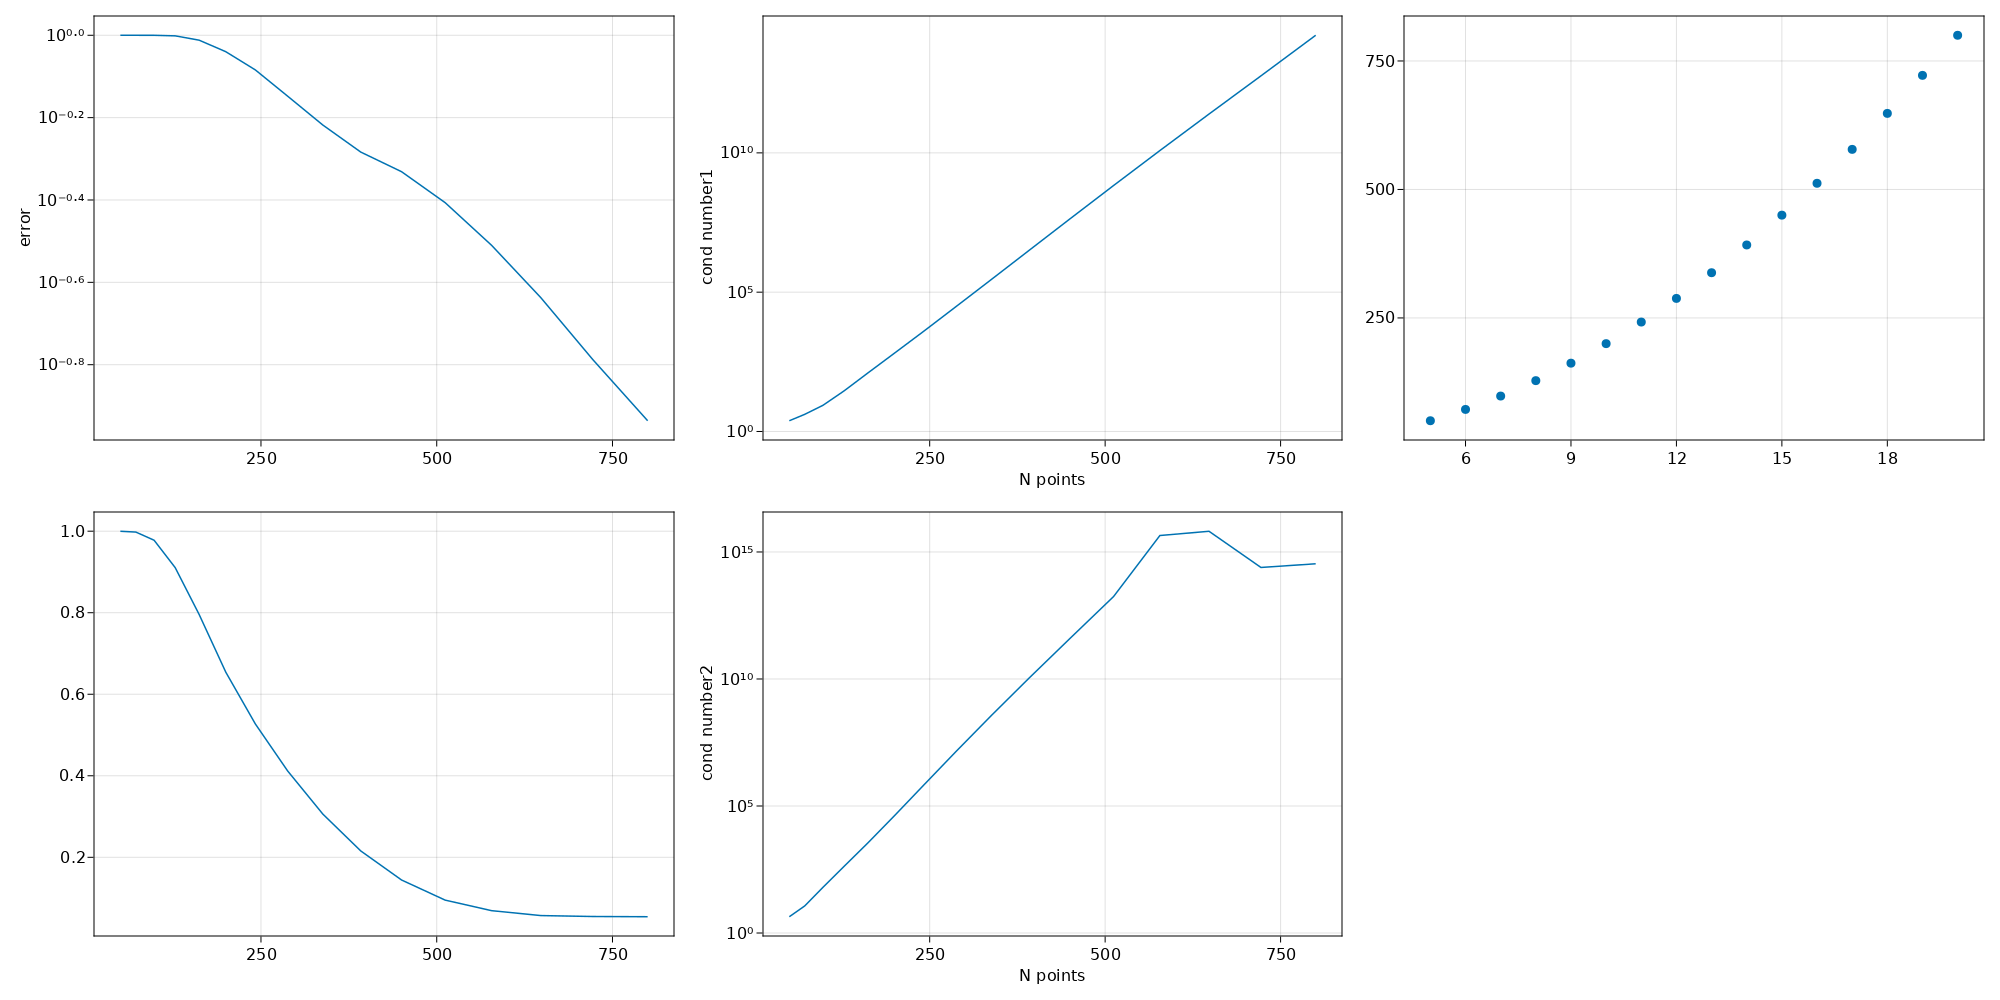

In [58]:
fig = Figure(resolution=(2000,1000))
subfig1 = fig[1, 1] = GridLayout()
subfig2 = fig[1, 2] = GridLayout()
subfig3 = fig[1, 3] = GridLayout()
subfig4 = fig[2, 1] = GridLayout()
subfig5 = fig[2, 2] = GridLayout()
ax1 = Axis(subfig1[1,1],yscale = log10,ylabel = "error")
ax2 = Axis(subfig2[1,1],ylabel="cond number1",xlabel = "N points",yscale = log10)
ax3 = Axis(subfig3[1,1])
ax4 = Axis(subfig4[1,1])
ax5 = Axis(subfig5[1,1],ylabel="cond number2",xlabel = "N points",yscale = log10)
CairoMakie.lines!(ax1,N_array,error_array)
CairoMakie.lines!(ax2,N_array,cond_number_array)
CairoMakie.scatter!(ax3,n_range,N_array)

CairoMakie.lines!(ax4,N_array2,error_array2)
CairoMakie.lines!(ax5,N_array2,cond_number_array2)
fig